In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from tensorflow import keras
from kerastuner.tuners import RandomSearch
print(tf.config.list_physical_devices('GPU'))
# Load the MNIST dataset
df = pd.read_csv("all_freq_test_unigram.csv")
y = pd.read_csv("actual_labels_unigram.csv")

def plot_loss(history):
    """
    Plots the training and validation loss versus epochs.

    Args:
    - history: History object returned by model.fit(), containing training/validation loss values.

    Returns:
    - None
    """
    # Extract training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Create an array of epoch numbers
    epochs = range(1, len(training_loss) + 1)

    # Plot loss vs epochs
    plt.plot(epochs, training_loss, 'b', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def compute_accuracy(actual_labels, predicted_labels):
    """
    Compute the accuracy of predicted labels compared to actual labels.
    
    Args:
    actual_labels (list): List of actual labels.
    predicted_labels (list): List of predicted labels.
    
    Returns:
    float: Accuracy of the predicted labels.
    """
    # Convert lists to numpy arrays if they're not already
    actual_labels = np.array(actual_labels)
    predicted_labels = np.array(predicted_labels)
    
    # Compute accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)
    
    return accuracy

def convert_labels_to_probabilities(labels):
    """
    Convert a 1D array of binary labels into a two-column array of probabilities.
    
    Args:
    labels (numpy.ndarray): 1D array of binary labels (0 for negative, 1 for positive).
    
    Returns:
    numpy.ndarray: Two-column array of probabilities, where the first column represents the probability of being positive 
                   and the second column represents the probability of being negative.
    """
    # Initialize the probabilities array
    if isinstance(labels, pd.DataFrame):
        labels = labels.values
        
    labels = labels.reshape(-1, 1)
    probabilities = np.zeros((len(labels), 2))
    
    # Set the first column to represent the probability of being positive
    probabilities[:, 0] = 1 - labels.ravel()  # ravel() is used to convert the array to 1D
    
    # Set the second column to represent the probability of being negative
    probabilities[:, 1] = labels.ravel()
    
    return probabilities
def save_to_csv(array, file_name):
    """
    Save the given array to a CSV file.

    Parameters:
        array (list or numpy array): The array to be saved.
        file_name (str): The name of the CSV file (include .csv extension).

    Returns:
        None
    """
    # Convert the array to a pandas DataFrame
    df = pd.DataFrame(array)

    # Write the DataFrame to the CSV file
    df.to_csv(file_name, index=False)

def rotate_2x2(matrix):
    # Swap elements diagonally
    rotated_matrix = np.array([[matrix[1][1], matrix[1][0]],
                               [matrix[0][1], matrix[0][0]]])
    return rotated_matrix


# Define a function to create the model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_layer1', min_value=1, max_value=20, step=2),
                           activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units_layer2', min_value=0, max_value=20, step=2),
                           activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Epoch 1/50
139/139 [==============================] - 4s 14ms/step - loss: 0.6909 - accuracy: 0.5397 - val_loss: 0.6845 - val_accuracy: 0.5307
Epoch 2/50
139/139 [==============================] - 1s 8ms/step - loss: 0.5965 - accuracy: 0.8181 - val_loss: 0.4380 - val_accuracy: 0.8555
Epoch 3/50
139/139 [==============================] - 1s 8ms/step - loss: 0.3321 - accuracy: 0.8805 - val_loss: 0.3328 - val_accuracy: 0.8619
Epoch 4/50
139/139 [==============================] - 1s 8ms/step - loss: 0.2431 - accuracy: 0.9103 - val_loss: 0.3274 - val_accuracy: 0.8581
Epoch 5/50
139/139 [==============================] - 1s 8ms/step - loss: 0.1995 - accuracy: 0.9318 - val_loss: 0.3349 - val_accuracy: 0.8593
Epoch 6/50
139/139 [==============================] - 1s 7ms/step - loss: 0.1661 - accuracy: 0.9462 - val_loss: 0.3361 - val_accuracy: 0.8670
Epoch 7/50
139/139 [==============================] - 1s 7ms/step - loss: 0.1390 - accuracy: 0.9605 - val_loss: 0.3500 - val_accuracy: 0.8657
Epoch

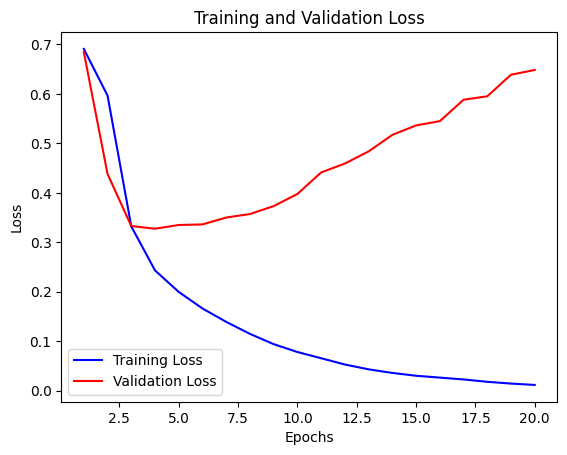

In [2]:
df = df.transpose()
X = df.values 
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

train= convert_labels_to_probabilities(y_train)
y_val= convert_labels_to_probabilities(y_val)
# Define the model
model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)), 
    layers.Dense(12, activation='relu'), 
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'), 
    layers.Dense(2, activation='softmax')
])
# Compile the model
model.compile(optimizer='adam',loss ="binary_crossentropy", metrics= ["accuracy"])

# Define your batch size
batch_size = 32
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
# Train the model on GPU
with tf.device('/GPU:0'):
     history = model.fit(X_train,train,epochs=50, batch_size= batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])  

predictions = model.predict(X_test)
save_to_csv(predictions, "NN_prediction_1.csv")
predicted_labels = [1 if pred[1] > pred[0] else 0 for pred in predictions]
save_to_csv(y_test, "NN_labels_1.csv")
acc= compute_accuracy(y_test, predicted_labels)
print(acc)
#Evaluate the model on the test set ,validation_data=(X_val, y_val)
cm = confusion_matrix(y_test, predicted_labels)
cm = rotate_2x2(cm)
print(cm)
plot_loss(history)


In [18]:
df = df.transpose()
X = df.values  # Input features (frequencies)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

train= convert_labels_to_probabilities(y_train)
y_val= convert_labels_to_probabilities(y_val)
# Initialize the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',  # Directory to save the tuning logs and checkpoints
    project_name='my_project'
)

# Perform hyperparameter tuning
tuner.search(X_train, train,
             epochs=45,
             validation_data=(X_val, y_val),
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 20 Complete [00h 00m 48s]
val_accuracy: 0.868563711643219

Best val_accuracy So Far: 0.8739837408065796
Total elapsed time: 00h 10m 59s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000026AA67D5C10>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 11187     
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 14)                28        
                                                                 
 dropout_1 (Dropout)         (None, 14)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                